In [1]:
import numpy as np
import seaborn as sns
from sklearn import datasets
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils

In [2]:
dataset = datasets.fetch_openml(name='mnist_784')

In [3]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [4]:
imgs=np.array(dataset['data'])

In [5]:
targets=np.array(dataset['target'])

In [6]:
dataset['details']

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [7]:
imgs.shape

(70000, 784)

In [8]:
targets.shape

(70000,)

56
0


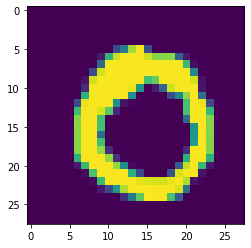

In [9]:
image_no=int(input())
plt.imshow(imgs[image_no].reshape(28,28))
print(targets[image_no])

C:\Users\dipay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

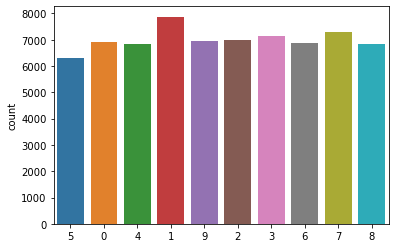

In [10]:
sns.countplot(targets)

C:\Users\dipay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

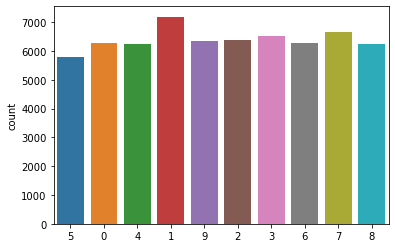

In [11]:
train_sample_size=64000
x_train,y_train=imgs[:train_sample_size],targets[:train_sample_size]
sns.countplot(y_train)

C:\Users\dipay\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

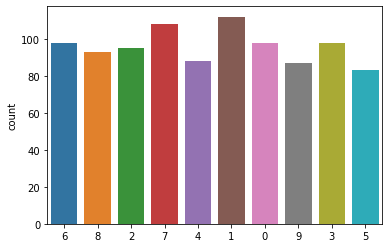

In [12]:
test_sample_size=960
x_test,y_test=imgs[-test_sample_size:len(imgs)],targets[-test_sample_size:len(targets)]
sns.countplot(y_test)

5
2


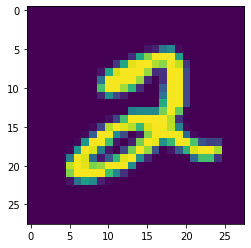

In [13]:
image_no=int(input())
plt.imshow(x_train[image_no].reshape(28,28))
print(y_train[image_no])

In [14]:
train = data_utils.TensorDataset(torch.from_numpy(x_train),torch.from_numpy(y_train.astype('float64')))
test = data_utils.TensorDataset(torch.from_numpy(x_test),torch.from_numpy(y_test.astype('float64')))


In [15]:
train_loader = data_utils.DataLoader(train, batch_size=64, shuffle=True)
test_loader = data_utils.DataLoader(test, batch_size=64, shuffle=True)

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [18]:
class nNet(nn.Module):
    def __init__(self):
        super(nNet,self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3,stride=1,padding =1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3,padding =1)
        self.conv3 = nn.Conv2d(128, 512, kernel_size=3,padding =1)
        self.max_pool2d = nn.MaxPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(7*7*512,64)  
        self.fc2 = nn.Linear(64,10)
        
    def forward(self,x):
        print(x.shape)
        x = F.relu(self.conv1(x))
        x = self.max_pool2d(x)
        print(x.shape)
        x = F.relu(self.conv2(x))
        x = self.max_pool2d(x)
        print(x.shape)
        x = F.relu(self.conv3(x))
        print('after conv3 '+str(x.shape))
        x=x.view(64,-1)
        print('after view '+str(x.shape))
        x = self.fc1(x)
        x = self.fc2(x)
        print('after fc2'+str(x.shape))
        return F.log_softmax(x)

In [19]:
model = nNet()
optimizer = optim.SGD(model.parameters(), lr=0.001,momentum=0.05)

In [20]:
print(model)

nNet(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool2d): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)


In [21]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(4)]

In [22]:
log_interval = 10
def train_fn(epoch):
    model.train()
    for batch_idx, (data,targets) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.view([-1, 1, 28, 28]).float())
        loss=F.nll_loss(output,targets.long())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(train_loader.dataset),100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append((batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            #torch.save(network.state_dict(), '/results/model.pth')
            #torch.save(optimizer.state_dict(), '/results/optimizer.pth')

In [23]:
def test_fn():
    print('test')
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data.view([-1, 1, 28, 28]).float())
            #print("output    "+ str(output.shape))
            #print(output.dtype)
            #print("target     "+ str(target.shape))
            test_loss += F.nll_loss(output, target.long(), size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, len(test_loader.dataset),100. * correct / len(test_loader.dataset)))

In [24]:
test_fn()
for epoch in range(1, 4):
    train_fn(epoch)
    test_fn()
    break

test
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])


C:\Users\dipay\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<ipython-input-18-c858ff291ae5>:27: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
C:\Users\dipay\anaconda3\lib\site-packages\torch\nn\_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [1920/64000 (3%)]	Loss: 0.987440
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
to

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [10240/64000 (16%)]	Loss: 0.210574


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [12800/64000 (20%)]	Loss: 0.207660
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [21120/64000 (33%)]	Loss: 0.068860
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


Train Epoch: 1 [23680/64000 (37%)]	Loss: 0.042112
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [29440/64000 (46%)]	Loss: 0.146885


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [32000/64000 (50%)]	Loss: 0.174124
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [40320/64000 (63%)]	Loss: 0.062312
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [48640/64000 (76%)]	Loss: 0.060395
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [51200/64000 (80%)]	Loss: 0.015474
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14

torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
Train Epoch: 1 [59520/64000 (93%)]	Loss: 0.121545
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


Train Epoch: 1 [62080/64000 (97%)]	Loss: 0.082766
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])
torch.Size([64, 1, 28, 28])
torch.Size([64, 64, 14, 14])
torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])


torch.Size([64, 128, 7, 7])
after conv3 torch.Size([64, 512, 7, 7])
after view torch.Size([64, 25088])
after fc2torch.Size([64, 10])

Test set: Avg. loss: 0.0785, Accuracy: 932/960 (97%)



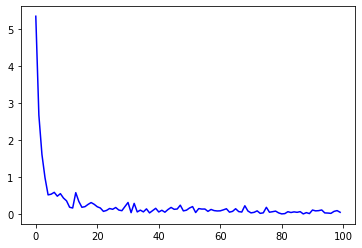

In [25]:
plt.plot(train_losses, color='blue')